In [ ]:
!python3 --version

In [ ]:
!pip install pyqubo

In [ ]:
!pip install openjij jijmodeling_transpiler

In [ ]:
!pip show pyqubo

In [288]:
from pyqubo import Array, Placeholder, solve_ising, Constraint, SubH, Model, Binary
import re, random, math
import numpy as np
import openjij as oj
import time 

In [289]:
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [290]:
resource_m = {'R0': ['m11', 'm12'], 'R1': ['m21', 'm22'], 'R2': ['m31', 'm32']}
machine_processing_time = {'m11': 1, 'm12': 2, 'm21': 3, 'm22': 1, 'm31': 1, 'm32': 3}
machine_cost = {'m11': 10, 'm12': 14, 'm21': 13, 'm22': 10, 'm31': 12, 'm32': 10}

resource_num = assign_resource_num(resource_m)

resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [291]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs, seed=None):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []
    job_tasks = {}  # タスク長を格納する辞書

    # シードを設定（指定された場合のみ）
    if seed is not None:
        random.seed(seed)

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

        # 各タスクに1から10の範囲でランダムなタスク長を割り当てる
        job_tasks[t11] = random.randint(1, 10)  # t11にランダムなタスク長を割り当て
        job_tasks[t12] = random.randint(1, 10)  # t12にランダムなタスク長を割り当て
        job_tasks[t13] = random.randint(1, 10)  # t13にランダムなタスク長を割り当て

    return resource_t, place, job, job_tasks

In [292]:
# R0, R1, R2ごとにマシンごとのタスク処理時間を保存する関数
def calculate_task_matrix(job_tasks, resource_t, resource_m, machine_processing_time):
    matrices = {}

    # 各リソースごとにマシンごとの行列を作成
    for resource, tasks in resource_t.items():
        machines = resource_m[resource]  # リソースに対応するマシンリスト
        num_tasks = len(tasks)
        num_machines = len(machines)

        # 結果を保存する行列（タスク数×マシン数）
        result_matrix = np.zeros((num_tasks, num_machines))

        for task_idx, task in enumerate(tasks):
            task_duration = job_tasks[task]  # タスクの処理時間を取得

            for machine_idx, machine in enumerate(machines):
                machine_time = machine_processing_time[machine]  # マシンの処理時間を取得

                # タスク長をマシン処理時間で割る
                result_matrix[task_idx, machine_idx] = task_duration / machine_time

        # リソースごとに行列を保存
        matrices[resource] = result_matrix

    return matrices

In [293]:
def calculate_machine_cost_matrix(resource_t, resource_m, machine_cost):
    matrices = {}

    # 各リソースごとにマシンごとの行列を作成
    for resource, tasks in resource_t.items():
        machines = resource_m[resource]  # リソースに対応するマシンリスト
        num_tasks = len(tasks)
        num_machines = len(machines)

        # 結果を保存する行列（タスク数×マシン数）
        result_matrix = np.zeros((num_tasks, num_machines))

        for machine_idx, machine in enumerate(machines):
            machine_cost_value = machine_cost[machine]  # マシンのコストを取得

            # 全タスクに対して同じマシンコストを適用
            result_matrix[:, machine_idx] = machine_cost_value

        # リソースごとに行列を保存
        matrices[resource] = result_matrix

    return matrices

In [294]:
num_jobs = 15
resource_t, place, job, job_tasks = generate_jobs_and_resources(num_jobs, seed=42)

In [295]:
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14,
 't61': 15,
 't62': 16,
 't63': 17,
 't71': 18,
 't72': 19,
 't73': 20,
 't81': 21,
 't82': 22,
 't83': 23,
 't91': 24,
 't92': 25,
 't93': 26,
 't101': 27,
 't102': 28,
 't103': 29,
 't111': 30,
 't112': 31,
 't113': 32,
 't121': 33,
 't122': 34,
 't123': 35,
 't131': 36,
 't132': 37,
 't133': 38,
 't141': 39,
 't142': 40,
 't143': 41,
 't151': 42,
 't152': 43,
 't153': 44}

In [296]:
t_num = len(transition_num)
r_num = len(resource_num)
time = 30
x = Array.create('x', (time, t_num), 'BINARY')  # binaryの宣言 

In [297]:
# 各リソースごとにタスクの処理時間をマシンで割った行列を計算
task_matrices = calculate_task_matrix(job_tasks, resource_t, resource_m, machine_processing_time)

In [298]:
# 各リソースごとにタスクの処理時間をマシンで割った行列を計算
cost_matrices = calculate_machine_cost_matrix(resource_t, resource_m, machine_processing_time)

In [299]:
def assign_tasks_to_machines(best_solution, task_number, num_tasks):
    schedule_dict = {}  # タスクとマシンの割り当てを格納する辞書

    for idx, value in best_solution.items():
        if value == 1:  # 値が1のときのみ格納
            machine_index = idx // num_tasks  # マシンインデックスを計算
            task_index = idx % num_tasks      # タスクインデックスを計算
            task_name = f't{task_index + 1}{task_number}'  # タスク番号はtask_number
            
            # マシン名を生成
            machine_name = f'm{task_number}{machine_index + 1}'
            
            # タスクとマシンの対応を辞書に保存
            schedule_dict[task_name] = machine_name

    return schedule_dict

In [300]:
# 各トランジションの処理時間の最大・最小値を求める関数
def calculate_time_ranges(job, job_tasks, task_resources, machine_processing_time, total_time):
    range_trantision_ptime = {}

    # 各ジョブに対して処理を行う
    for idx, j in enumerate(job):
        # 最後のタスクの上限は total_time になる
        ub = total_time
        
        for i in reversed(range(len(j))):  # タスクを逆順に処理
            task = j[i]

            # 下限（lb）の計算: 現在のタスクまでの合計処理時間（小数点を切り上げ）
            lb = 0
            if i != 0:
                lb = sum([math.ceil(job_tasks[j[k]] / machine_processing_time[task_resources[j[k]]]) for k in range(i)])

            # 上限（ub）の計算: 次のタスクの上限から現在のタスクの処理時間を引く
            if i < len(j) - 1:  # 最後のタスクでない場合
                ub -= math.ceil(job_tasks[task] / machine_processing_time[task_resources[task]])

            # 計算結果を保存
            range_trantision_ptime[task] = [lb, ub]

    # 指定された順序でタスクを整列
    ordered_keys = sorted(range_trantision_ptime.keys(), key=lambda x: (int(x[1:]), int(x[2:])))
    ordered_ranges = {key: range_trantision_ptime[key] for key in ordered_keys}

    return ordered_ranges

## マシンリソースの割り当ての目的関数

In [301]:
import jijmodeling as jm
import jijmodeling_transpiler as jmt

# 問題の定義
problem = jm.Problem("Task Scheduling")

# プレースホルダーとバイナリ変数の定義
M = task_matrices['R0'].ndim  # マシンの数
T = task_matrices['R0'].shape[0]  # タスクの数
a = jm.Placeholder("a", ndim=2)  # タスク長を表すプレースホルダー (M, T)
x = jm.BinaryVar("x", shape=(M, T))  # バイナリ変数 (M, T)
t = jm.Element("t", (0, T))
m = jm.Element("m", (0, M))

# エネルギー関数を問題に追加
problem += jm.sum((m, m!=0),(jm.sum(t, a[0, t] * x[0, t]) - jm.sum(t, a[m, t] * x[m, t])) ** 2)

# 各タスクtは必ず1つのマシンmに割り当てられる
problem += jm.Constraint("task_assignment", jm.sum(m, x[m, t]) == 1, forall=t)


In [302]:
problem

In [303]:
def process_optimization(matrix_name, matrix_type='task'):
    if matrix_type == 'task':
        matrix_data = task_matrices[matrix_name].T
    elif matrix_type == 'cost':
        matrix_data = cost_matrices[matrix_name].T
    else:
        raise ValueError("matrix_type must be 'task' or 'cost'")
    
    instance_data = {
        "a": matrix_data
    }
    
    # compile the model using jijmodeling_transpiler
    compiled_model = jmt.core.compile_model(problem, instance_data, {})

    # QUBO形式に変換
    pubo_builder = jmt.core.pubo.transpile_to_pubo(
        compiled_model=compiled_model, 
        relax_method=jmt.core.pubo.RelaxationMethod.AugmentedLagrangian
    )

    # QUBOと定数項を取得
    qubo, const = pubo_builder.get_qubo_dict(multipliers={})
    
    return pubo_builder, compiled_model, qubo, const

## 処理時間優先としたマシンリソースの割当て

In [304]:
R0_task_pubo_builder,R0_task_compiled_model,R0_task_qubo,R0_const = process_optimization('R0','task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R0_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R0_task_pubo_builder, R0_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1], -14.49861111, 1),
           ([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1], -14.97777778, 1),
           ([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0], -14.97777778, 1),
           ([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1], -14.99861111, 1),
           ([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], -14.99444444, 1),
           ([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0], -14.99444444, 1),
           ([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0], -14.99444444, 1),
           ([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0], -14.76527778, 1),
           ([0,

In [305]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 1
x[0, 1] = 0
x[0, 2] = 1
x[0, 3] = 0
x[0, 4] = 1
x[0, 5] = 0
x[0, 6] = 1
x[0, 7] = 0
x[0, 8] = 0
x[0, 9] = 0
x[0, 10] = 1
x[0, 11] = 1
x[0, 12] = 0
x[0, 13] = 1
x[0, 14] = 0
x[1, 0] = 0
x[1, 1] = 1
x[1, 2] = 0
x[1, 3] = 1
x[1, 4] = 0
x[1, 5] = 1
x[1, 6] = 0
x[1, 7] = 1
x[1, 8] = 1
x[1, 9] = 1
x[1, 10] = 0
x[1, 11] = 0
x[1, 12] = 1
x[1, 13] = 0
x[1, 14] = 1


In [306]:
schedule_task_dict = assign_tasks_to_machines(best_solution,1,num_tasks)
schedule_task_dict

{'t11': 'm11',
 't31': 'm11',
 't51': 'm11',
 't71': 'm11',
 't111': 'm11',
 't121': 'm11',
 't141': 'm11',
 't21': 'm12',
 't41': 'm12',
 't61': 'm12',
 't81': 'm12',
 't91': 'm12',
 't101': 'm12',
 't131': 'm12',
 't151': 'm12'}

In [307]:
R1_task_pubo_builder,R1_task_compiled_model,R1_task_qubo,R1_task_const = process_optimization('R1', 'task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R1_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R1_task_pubo_builder, R1_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1], -14.8       , 1),
           ([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0], -14.97777778, 1),
           ([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], -14.9382716 , 1),
           ([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], -14.99753086, 1),
           ([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], -14.9382716 , 1),
           ([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], -14.70123457, 1),
           ([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1], -14.87901235, 1),
           ([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1], -14.97777778, 1),
           ([1,

In [308]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 1
x[0, 1] = 1
x[0, 2] = 0
x[0, 3] = 0
x[0, 4] = 0
x[0, 5] = 1
x[0, 6] = 1
x[0, 7] = 1
x[0, 8] = 1
x[0, 9] = 0
x[0, 10] = 1
x[0, 11] = 1
x[0, 12] = 1
x[0, 13] = 1
x[0, 14] = 0
x[1, 0] = 0
x[1, 1] = 0
x[1, 2] = 1
x[1, 3] = 1
x[1, 4] = 1
x[1, 5] = 0
x[1, 6] = 0
x[1, 7] = 0
x[1, 8] = 0
x[1, 9] = 1
x[1, 10] = 0
x[1, 11] = 0
x[1, 12] = 0
x[1, 13] = 0
x[1, 14] = 1


In [309]:
schedule_task_dict2 = assign_tasks_to_machines(best_solution,2,num_tasks)
schedule_task_dict2

{'t12': 'm21',
 't22': 'm21',
 't62': 'm21',
 't72': 'm21',
 't82': 'm21',
 't92': 'm21',
 't112': 'm21',
 't122': 'm21',
 't132': 'm21',
 't142': 'm21',
 't32': 'm22',
 't42': 'm22',
 't52': 'm22',
 't102': 'm22',
 't152': 'm22'}

In [310]:
R2_task_pubo_builder,R2_task_compiled_model,R2_task_qubo,R2_task_const = process_optimization('R2', 'task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R2_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R2_task_pubo_builder, R2_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1], -14.99777778, 1),
           ([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1], -14.89111111, 1),
           ([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1], -14.94444444, 1),
           ([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1], -14.82      , 1),
           ([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], -14.98      , 1),
           ([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1], -14.99777778, 1),
           ([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1], -14.94444444, 1),
           ([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1], -14.99777778, 1),
           ([0,

In [311]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 0
x[0, 1] = 0
x[0, 2] = 1
x[0, 3] = 1
x[0, 4] = 0
x[0, 5] = 0
x[0, 6] = 0
x[0, 7] = 0
x[0, 8] = 1
x[0, 9] = 0
x[0, 10] = 0
x[0, 11] = 0
x[0, 12] = 0
x[0, 13] = 1
x[0, 14] = 0
x[1, 0] = 1
x[1, 1] = 1
x[1, 2] = 0
x[1, 3] = 0
x[1, 4] = 1
x[1, 5] = 1
x[1, 6] = 1
x[1, 7] = 1
x[1, 8] = 0
x[1, 9] = 1
x[1, 10] = 1
x[1, 11] = 1
x[1, 12] = 1
x[1, 13] = 0
x[1, 14] = 1


In [312]:
schedule_task_dict3 = assign_tasks_to_machines(best_solution,3,num_tasks)
schedule_task_dict3

{'t33': 'm31',
 't43': 'm31',
 't93': 'm31',
 't143': 'm31',
 't13': 'm32',
 't23': 'm32',
 't53': 'm32',
 't63': 'm32',
 't73': 'm32',
 't83': 'm32',
 't103': 'm32',
 't113': 'm32',
 't123': 'm32',
 't133': 'm32',
 't153': 'm32'}

In [313]:
# 辞書をまとめる
combined_task_schedule = {**schedule_task_dict, **schedule_task_dict2, **schedule_task_dict3}

# タスク名を数値に変換してソート
sorted_task_schedule = dict(sorted(combined_task_schedule.items(), key=lambda x: (int(x[0][1:]))))
sorted_schedule = sorted_task_schedule
sorted_task_schedule

{'t11': 'm11',
 't12': 'm21',
 't13': 'm32',
 't21': 'm12',
 't22': 'm21',
 't23': 'm32',
 't31': 'm11',
 't32': 'm22',
 't33': 'm31',
 't41': 'm12',
 't42': 'm22',
 't43': 'm31',
 't51': 'm11',
 't52': 'm22',
 't53': 'm32',
 't61': 'm12',
 't62': 'm21',
 't63': 'm32',
 't71': 'm11',
 't72': 'm21',
 't73': 'm32',
 't81': 'm12',
 't82': 'm21',
 't83': 'm32',
 't91': 'm12',
 't92': 'm21',
 't93': 'm31',
 't101': 'm12',
 't102': 'm22',
 't103': 'm32',
 't111': 'm11',
 't112': 'm21',
 't113': 'm32',
 't121': 'm11',
 't122': 'm21',
 't123': 'm32',
 't131': 'm12',
 't132': 'm21',
 't133': 'm32',
 't141': 'm11',
 't142': 'm21',
 't143': 'm31',
 't151': 'm12',
 't152': 'm22',
 't153': 'm32'}

In [314]:
range_trantision_ptime = calculate_time_ranges(job, job_tasks, sorted_task_schedule, machine_processing_time, time)

range_trantision_ptime

{'t11': [0, 27],
 't12': [2, 29],
 't13': [3, 30],
 't21': [0, 26],
 't22': [2, 28],
 't23': [4, 30],
 't31': [0, 19],
 't32': [2, 21],
 't33': [11, 30],
 't41': [0, 18],
 't42': [5, 23],
 't43': [12, 30],
 't51': [0, 27],
 't52': [1, 28],
 't53': [3, 30],
 't61': [0, 25],
 't62': [2, 27],
 't63': [5, 30],
 't71': [0, 26],
 't72': [1, 27],
 't73': [4, 30],
 't81': [0, 22],
 't82': [5, 27],
 't83': [8, 30],
 't91': [0, 22],
 't92': [4, 26],
 't93': [8, 30],
 't101': [0, 26],
 't102': [1, 27],
 't103': [4, 30],
 't111': [0, 22],
 't112': [6, 28],
 't113': [8, 30],
 't121': [0, 24],
 't122': [4, 28],
 't123': [6, 30],
 't131': [0, 26],
 't132': [1, 27],
 't133': [4, 30],
 't141': [0, 22],
 't142': [6, 28],
 't143': [8, 30],
 't151': [0, 26],
 't152': [3, 29],
 't153': [4, 30]}

## リソースコストを優先とした割り当て

In [315]:
# R0_cost_pubo_builder,R0_cost_compiled_model,R0_cost_qubo,R0_cost_const = process_optimization('R0', 'cost')

# # set sampler_op
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R0_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R0_cost_pubo_builder, R0_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [316]:
# best_solution = response.first.sample

# # マシン数とタスク数を設定
# num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
# num_tasks = num_jobs                     # タスク数を設定

# # 結果を表示
# for idx, value in best_solution.items():
#     machine_index = idx // num_tasks  # マシンインデックスを計算
#     task_index = idx % num_tasks       # タスクインデックスを計算
#     print(f"x[{machine_index}, {task_index}] = {value}")

In [317]:
# schedule_cost_dict = assign_tasks_to_machines(best_solution,1,num_tasks)
# schedule_cost_dict

In [318]:
# R1_cost_pubo_builder,R1_cost_compiled_model,R1_cost_qubo,R0_cost_const = process_optimization('R1', 'cost')

# # set sampler
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R1_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R1_cost_pubo_builder, R1_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [319]:
# best_solution = response.first.sample

# # マシン数とタスク数を設定
# num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
# num_tasks = num_jobs                     # タスク数を設定

# # 結果を表示
# for idx, value in best_solution.items():
#     machine_index = idx // num_tasks  # マシンインデックスを計算
#     task_index = idx % num_tasks       # タスクインデックスを計算
#     print(f"x[{machine_index}, {task_index}] = {value}")

In [320]:
# schedule_cost_dict2 = assign_tasks_to_machines(best_solution,2,num_tasks)
# schedule_cost_dict2

In [321]:
# R2_cost_pubo_builder,R2_cost_compiled_model,R2_cost_qubo,R0_cost_const = process_optimization('R2', 'cost')

# # set sampler
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R1_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R2_cost_pubo_builder, R2_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [322]:
# schedule_cost_dict3 = assign_tasks_to_machines(best_solution,3,num_tasks)
# schedule_cost_dict3

In [323]:
# # 辞書をまとめる
# combined_cost_schedule = {**schedule_cost_dict, **schedule_cost_dict2, **schedule_cost_dict3}

# # タスク名を数値に変換してソート
# sorted_cost_schedule = dict(sorted(combined_cost_schedule.items(), key=lambda x: (int(x[0][1:]))))
# sorted_schedule = sorted_cost_schedule
# sorted_cost_schedule

In [324]:
# range_trantision_ptime = calculate_time_ranges(job, job_tasks, sorted_cost_schedule, machine_processing_time, time)

# range_trantision_ptime

## openjijで計算

## H_firing

In [368]:
range_trantision_ptime

{'t11': [0, 27],
 't12': [2, 29],
 't13': [3, 30],
 't21': [0, 26],
 't22': [2, 28],
 't23': [4, 30],
 't31': [0, 19],
 't32': [2, 21],
 't33': [11, 30],
 't41': [0, 18],
 't42': [5, 23],
 't43': [12, 30],
 't51': [0, 27],
 't52': [1, 28],
 't53': [3, 30],
 't61': [0, 25],
 't62': [2, 27],
 't63': [5, 30],
 't71': [0, 26],
 't72': [1, 27],
 't73': [4, 30],
 't81': [0, 22],
 't82': [5, 27],
 't83': [8, 30],
 't91': [0, 22],
 't92': [4, 26],
 't93': [8, 30],
 't101': [0, 26],
 't102': [1, 27],
 't103': [4, 30],
 't111': [0, 22],
 't112': [6, 28],
 't113': [8, 30],
 't121': [0, 24],
 't122': [4, 28],
 't123': [6, 30],
 't131': [0, 26],
 't132': [1, 27],
 't133': [4, 30],
 't141': [0, 22],
 't142': [6, 28],
 't143': [8, 30],
 't151': [0, 26],
 't152': [3, 29],
 't153': [4, 30]}

In [369]:
range_trantision_ptime['t11'][1]

27

In [325]:
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):
        sigma_h_firing = 0.0
        for k in range(range_trantision_ptime[j[i]][0], range_trantision_ptime[j[i]][1]):
            t = transition_num[j[i]]
            sigma_h_firing += Binary(f'x_{k}_{t}')  # Binary変数として定義
        
        # Constraintに渡す前にpyquboのExpressionとして構築
        constraint_expr = (1 - sigma_h_firing) * (1 - sigma_h_firing)  # **2の代わりに乗算を使用
        H_firing += Constraint(constraint_expr, label=f"one_fired_t{idx + 1}{i + 1}")

## H_conflict

In [326]:
# H_conflict制約の更新
H_conflict = 0.0
for i in range(len(resource_m)):
    for j1 in range(len(job)):
        t1 = transition_num[job[j1][i]]
        for j2 in range(len(job)):
            t2 = transition_num[job[j2][i]]
            if j1 != j2:
                lb = range_trantision_ptime[job[j1][i]][0]
                ub = range_trantision_ptime[job[j1][i]][1]
                for k1 in range(lb, ub):
                    for k2 in range(k1 + 1, range_trantision_ptime[job[j2][i]][1]):
                        # Binary変数として定義
                        x_k1_t1 = Binary(f'x_{k1}_{t1}')
                        x_k2_t2 = Binary(f'x_{k2}_{t2}')
                        
                        # 制約式を構築
                        constraint_expr = x_k1_t1 * x_k2_t2
                        
                        # Constraintとして追加
                        H_conflict += Constraint(constraint_expr, label=f"conflict{t1}")

## H_precedence

In [327]:
H_precedence = 0.0
for idx, j in enumerate(job):
    for i in range(len(j) - 1):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        
        for r1 in resource_m['R' + str(i)]:
            if i + 1 < len(j):
                for r2 in resource_m['R' + str(i + 1)]:
                    t1 = transition_num[j[i]]
                    t2 = transition_num[j[i + 1]]
                    
                    for k1 in range(lb, ub):
                        fd = k1 + machine_processing_time[r1]
                        for k2 in range(fd, range_trantision_ptime[j[i + 1]][1]):
                            # Binary変数として定義
                            x_k1_t1 = Binary(f'x_{k1}_{t1}')
                            x_k2_t2 = Binary(f'x_{k2}_{t2}')
                            
                            # 制約式を構築
                            constraint_expr = x_k1_t1 * x_k2_t2
                            
                            # Constraintとして追加
                            H_precedence += Constraint(
                                constraint_expr,
                                label=f"precedence{k1}{t1}{k2}{t2}"
                            )

## H_resourceCost

In [328]:
H_resourceCost = 0.0
for j in range(len(job)):
    for i in range(len(job[j])):
        # リソースと関連するパラメータの取得
        resource = sorted_schedule[job[j][i]]
        resource_cost = machine_cost[resource]  # rc をより明確な名前に変更
        processing_time = machine_processing_time[resource]  # fd をより明確な名前に変更
        
        # 時間範囲の設定
        lb = range_trantision_ptime[job[j][i]][0]
        ub = range_trantision_ptime[job[j][i]][1]
        t = transition_num[job[j][i]]
        
        # コスト係数の計算
        cost_coefficient = resource_cost * processing_time
        
        for k in range(lb, ub):
            # Binary変数として定義
            x_k_t = Binary(f'x_{k}_{t}')
            
            # 目的関数の項を構築
            # コスト係数 * バイナリ変数
            term = cost_coefficient * x_k_t
            
            # 目的関数に追加
            H_resourceCost += term

## H_waitingTime

In [329]:
H_waitingTime = 0.0
for j in range(len(job)):
    for i in range(len(job[j]) - 1):
        lb1 = range_trantision_ptime[job[j][i + 1]][0]
        ub1 = range_trantision_ptime[job[j][i + 1]][1]
        t1 = transition_num[job[j][i + 1]]
        
        lb2 = range_trantision_ptime[job[j][i]][0]
        ub2 = range_trantision_ptime[job[j][i]][1]
        t2 = transition_num[job[j][i]]
        
        for k1 in range(lb1, ub1):
            for k2 in range(lb2, ub2):
                # 待ち時間の計算
                waiting_time = k1 - (k2 + machine_processing_time[sorted_schedule[job[j][i]]])
                
                if waiting_time >= 0:
                    # Binary変数として定義
                    x_k2_t2 = Binary(f'x_{k2}_{t2}')
                    x_k1_t1 = Binary(f'x_{k1}_{t1}')
                    
                    # 目的関数の項を構築
                    # 係数 * 変数1 * 変数2 の形式で構築
                    term = waiting_time * x_k2_t2 * x_k1_t1
                    
                    # 目的関数に追加
                    H_waitingTime += term

In [330]:
from collections import OrderedDict

# ハミルトニアンを構築
A = Placeholder("A")
B = Placeholder("B")
C = Placeholder("C")
D = Placeholder("D")
E = Placeholder("E")

# H = SubH(A * H_firing, "SubH1") + SubH(B * H_conflict, "SubH2") + SubH(C * H_precedence, "SubH3") + D * H_resourceCost + E * H_waitingTime
H = SubH(A * H_firing, "SubH1") + SubH(B * H_conflict, "SubH2") + SubH(C * H_precedence, "SubH3") + E * H_waitingTime

# モデルをコンパイル
model = H.compile()

# feed_dict = {"A": 600.0, "B": 150, "C": 250.0, "D": 1, "E": 10} #E = {1,10,20,30,40,50}の計6パターン D=1,5,8,10,13
feed_dict = {"A": 600.0, "B": 150, "C": 250.0, "E": 20}

In [331]:
# QUBOを作成
bqm = model.to_bqm(feed_dict=feed_dict)

# QUBOの変数数（量子ビットの数）を確認
num_qubits = len(bqm.variables)
print(f"Number of qubits: {num_qubits}")

# アニーリング回数
num_iterations = 100

# QUBOを辞書形式に変換
qubo_dict = bqm.to_qubo()[0]

# OpenJijのSamplerを使用してQUBOを解く
sampler = oj.SASampler()

response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)
print("end")

Number of qubits: 1148
end


In [332]:
# サンプリング結果をデコード
decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

# print(decoded_samples)

# 最良のサンプルを選択
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))

# # 最悪のサンプルを選択（エネルギーが最大のもの）
# worst_sample = max(decoded_samples, key=lambda x: x.energy)

In [333]:
# 最良のサンプルの各サブハミルトニアンの値を計算する関数
def calculate_subh_energy(subh, sample, feed_dict):
    """
    各サブハミルトニアンの計算
    Args:
        subh: サブハミルトニアン
        sample: 最良のサンプル
        feed_dict: ハイパーパラメータ
    Returns:
        ハミルトニアンの各項のエネルギーを計算する
    """
    subh_model = subh.compile()
    subh_qubo, subh_offset = subh_model.to_qubo(feed_dict=feed_dict)
    subh_energy = sum(subh_qubo.get((v, v), 0) * sample[v] for v in sample) #一次項の計算
    for (v1, v2), coeff in subh_qubo.items(): #二次の項の計算
        if v1 != v2:
            subh_energy += coeff * sample[v1] * sample[v2]
    return subh_energy + subh_offset

In [335]:
resource_cost = calculate_subh_energy(H_resourceCost, best_sample.sample, feed_dict)
waiting_time = calculate_subh_energy(H_waitingTime, best_sample.sample, feed_dict)

# # 最悪のサンプルのリソースコストと待ち時間を取得
# worst_resource_cost = calculate_subh_energy(H_resourceCost, worst_sample.sample, feed_dict)
# worst_waiting_time = calculate_subh_energy(H_waitingTime, worst_sample.sample, feed_dict)

# デコードされた解を表示
print("Decoded Solution:")
for variable, value in best_sample.sample.items():
    print(f"{variable}: {value}")

print("\nEnergy:")
print(best_sample.energy)

print(best_sample.constraints(only_broken=True))
print("number of broken constarint = {}".format(num_broken))

Decoded Solution:
x_12_23: 0
x_0_0: 0
x_19_22: 0
x_12_29: 0
x_6_32: 0
x_0_36: 0
x_14_12: 0
x_15_18: 0
x_23_42: 0
x_8_5: 0
x_13_31: 0
x_0_12: 0
x_4_3: 0
x_19_26: 0
x_14_27: 0
x_17_25: 0
x_18_15: 0
x_28_8: 0
x_6_25: 0
x_11_38: 0
x_10_19: 0
x_13_37: 0
x_11_1: 0
x_11_15: 0
x_5_3: 0
x_10_34: 0
x_18_40: 0
x_19_1: 0
x_19_39: 0
x_7_17: 0
x_12_34: 0
x_20_37: 0
x_26_40: 0
x_12_18: 0
x_9_28: 0
x_11_11: 0
x_3_37: 0
x_26_31: 0
x_18_11: 0
x_10_25: 0
x_17_28: 0
x_10_37: 0
x_0_6: 0
x_26_14: 0
x_26_44: 0
x_10_21: 0
x_25_13: 0
x_6_19: 0
x_10_30: 0
x_14_9: 0
x_10_26: 0
x_14_34: 0
x_0_24: 0
x_10_29: 0
x_7_20: 0
x_23_25: 0
x_13_33: 0
x_11_29: 0
x_12_25: 0
x_9_13: 0
x_10_3: 0
x_17_11: 0
x_27_4: 0
x_10_40: 0
x_21_41: 0
x_10_44: 0
x_11_26: 0
x_19_43: 0
x_11_0: 0
x_13_22: 0
x_9_9: 0
x_10_43: 0
x_0_15: 0
x_12_27: 0
x_22_29: 0
x_13_17: 0
x_11_3: 0
x_4_11: 1
x_12_4: 0
x_16_19: 1
x_10_8: 0
x_16_1: 1
x_12_10: 0
x_10_9: 0
x_19_41: 0
x_5_44: 0
x_22_31: 0
x_10_5: 0
x_4_5: 0
x_17_10: 0
x_10_22: 0
x_13_10: 0
x_11_16: 0


In [336]:
def extractVariable(s):
    """
    変数名を解析する関数
    例: 'x_1_2' -> ['x', '1', '2']
    """
    # x_数字_数字 の形式を想定
    pattern = r'x_(\d+)_(\d+)'
    match = re.match(pattern, s)
    if match:
        return ['x', match.group(1), match.group(2)]
    return None

In [337]:
# メインの処理部分
keys = [k for k, v in best_sample.sample.items() if v == 1]
keys

['x_4_11',
 'x_16_19',
 'x_16_1',
 'x_16_18',
 'x_16_21',
 'x_16_2',
 'x_16_29',
 'x_16_31',
 'x_7_32',
 'x_16_37',
 'x_7_41',
 'x_16_28',
 'x_16_41',
 'x_3_29',
 'x_16_8',
 'x_16_14',
 'x_16_26',
 'x_16_5',
 'x_16_43',
 'x_16_0',
 'x_16_9',
 'x_16_4',
 'x_16_10',
 'x_16_11',
 'x_16_12',
 'x_16_13',
 'x_16_32',
 'x_16_15',
 'x_16_16',
 'x_3_22',
 'x_16_17',
 'x_16_23',
 'x_16_3',
 'x_16_30',
 'x_1_40',
 'x_16_33',
 'x_16_34',
 'x_16_36',
 'x_16_40',
 'x_16_42',
 'x_16_44',
 'x_16_24',
 'x_16_6',
 'x_16_7',
 'x_16_38',
 'x_16_20',
 'x_6_11',
 'x_16_27',
 'x_1_4',
 'x_16_35',
 'x_1_1',
 'x_1_16',
 'x_16_22',
 'x_1_25',
 'x_1_31',
 'x_16_39',
 'x_5_31',
 'x_16_25',
 'x_5_23',
 'x_2_10',
 'x_2_14',
 'x_2_25',
 'x_2_31',
 'x_3_17',
 'x_3_20',
 'x_3_34',
 'x_3_38',
 'x_3_40',
 'x_4_23',
 'x_4_26',
 'x_4_35',
 'x_4_40',
 'x_4_8',
 'x_5_11',
 'x_5_35',
 'x_5_41',
 'x_7_11',
 'x_7_23',
 'x_7_26',
 'x_7_8',
 'x_9_8']

In [338]:
ans = []

for k in keys:
    ans.append(extractVariable(k))

sort_ans = list(range(len(ans)))

for i in ans:
    sort_ans[int(i[2])] = i

sort_ans

[['x', '16', '0'],
 ['x', '1', '1'],
 ['x', '16', '2'],
 ['x', '16', '3'],
 ['x', '1', '4'],
 ['x', '16', '5'],
 ['x', '16', '6'],
 ['x', '16', '7'],
 ['x', '9', '8'],
 ['x', '16', '9'],
 ['x', '2', '10'],
 ['x', '7', '11'],
 ['x', '16', '12'],
 ['x', '16', '13'],
 ['x', '2', '14'],
 ['x', '16', '15'],
 ['x', '1', '16'],
 ['x', '3', '17'],
 ['x', '16', '18'],
 ['x', '16', '19'],
 ['x', '3', '20'],
 ['x', '16', '21'],
 ['x', '16', '22'],
 ['x', '7', '23'],
 ['x', '16', '24'],
 ['x', '2', '25'],
 ['x', '7', '26'],
 ['x', '16', '27'],
 ['x', '16', '28'],
 ['x', '3', '29'],
 ['x', '16', '30'],
 ['x', '2', '31'],
 ['x', '16', '32'],
 ['x', '16', '33'],
 ['x', '3', '34'],
 ['x', '5', '35'],
 ['x', '16', '36'],
 ['x', '16', '37'],
 ['x', '3', '38'],
 ['x', '16', '39'],
 ['x', '4', '40'],
 ['x', '5', '41'],
 ['x', '16', '42'],
 ['x', '16', '43'],
 ['x', '16', '44'],
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,

In [339]:
print("Resource Cost : {}".format(resource_cost))
print("Waiting Time : {}".format(waiting_time))

Resource Cost : 1112.0
Waiting Time : 0.0


In [340]:
subH_list = ['SubH1','SubH2','SubH3']
is_feasible = True

for i in subH_list:
    if best_sample.subh[i] != 0:
        is_feasible = False
if is_feasible:
    print('Feasible!!')
else:
    if best_sample.subh[i] != 0:
        print("["+str(i)+"]=",best_sample.subh[i])

Feasible!!


## データをcsvに保存する

In [341]:
# import csv
# import os
# from datetime import datetime

# now = datetime.now()
# timestamp = now.strftime('%Y-%m-%d')

# # 保存するファイル名
# csv_filename = f'./search/t_30/1107/{timestamp}_patt12_job{num_jobs}.csv' #任意のファイル名

# # CSVファイルが存在するかどうかを確認
# file_exists = os.path.isfile(csv_filename)

# constraint_error = best_sample.constraints(only_broken=True)
# feasible = 0 if is_feasible else constraint_error 
# #制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# # データをリストのリストとして準備
# # data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
# data = [[num_iterations, resource_cost, waiting_time, feasible]]

# # ファイルが存在しない場合はヘッダーを追加
# if not file_exists:
#     with open(csv_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
#         writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
#         writer.writerows(data)
# else:
#     # ファイルが存在する場合は追記
#     with open(csv_filename, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)

## plot

In [343]:
# import pandas as pd
# import re
# import glob

# # ファイルパスを取得
# file_paths = glob.glob("./search/t_30/1107/2024-11-07_patt*_job15.csv")
# # file_paths = [f for f in file_paths if re.search(r'patt([1-6])_job15\.csv$', f)] #processing_time
# file_paths = [f for f in file_paths if re.search(r'patt([7-9]|1[0-2])_job15\.csv$', f)] #resourcecost

# file_paths.sort(key=lambda x: int(re.search(r'patt(\d+)', x).group(1)))

# # 出力用のリスト
# output = []

# # 各ファイルに対して処理
# for file_path in file_paths:
#     # データを読み込む
#     data = pd.read_csv(file_path)

#     # ファイル名から「patt」の番号を抽出
#     # patt_number = re.search(r'patt([1-6])', file_path).group(1) #processing_time
#     patt_number = re.search(r'patt([7-9]|1[0-2])', file_path).group(1) #resourcecost


#     # feasibleを文字列型に変換してフィルタ
#     data['feasible'] = data['feasible'].astype(str)
#     feasible_zero = data[data['feasible'] == '0']

#     # 各列の平均を計算
#     iteration_mean = feasible_zero['iteration'].mean()
#     resource_cost_mean = feasible_zero['resource_cost'].mean()
#     waiting_time_mean = feasible_zero['waiting_time'].mean()

#     # 1行分の辞書を追加
#     output.append({
#         'iteration': int(iteration_mean),
#         'mean_resource_cost': resource_cost_mean,
#         'mean_waiting_time': waiting_time_mean,
#         'label': f"{patt_number}_{int(iteration_mean)}"
#     })

# # 出力をデータフレーム化
# output_df = pd.DataFrame(output)
# output_df


In [344]:
# output_df.to_csv('./search/t_30/1107/processing_time.csv', index=False)

In [345]:
# output_df.to_csv('./search/t_30/1107/resourcecost.csv', index=False)

In [346]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # データを読み込む
# df = pd.read_csv('./search/t_30/1107/resourcecost.csv')

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 横軸を 'label' 列のデータで、縦軸を 'mean_resource_cost' に設定してプロット
# x_indices = np.arange(len(df['label']))

# ax1.plot(
#     x_indices, 
#     df['mean_resource_cost'], 
#     marker='o', linestyle='-', color='b', 
#     label='Mean Resource Cost'
# )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 右のY軸を 'mean_waiting_time' に設定してプロット
# ax2.plot(
#     x_indices, 
#     df['mean_waiting_time'], 
#     marker='x', linestyle='--', color='r', 
#     label='Mean Waiting Time'
# )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('Parameter E')
# ax1.set_ylabel('Resource Cost')
# ax2.set_ylabel('Waiting Time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()

In [347]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # 読み込むCSVファイルのリスト
# csv_files = [
#     './search/t_30/1107/processing_time.csv',
#     './search/t_30/1107/resourcecost.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_1_to_6.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_7_to_12.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_13_to_18.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_19_to_24.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_25_to_30.csv'
# ]

# # 凡例のラベルをDの値に対応させる
# legend_labels = ['fast', 'eco', 'D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# # カラーマップを作成（viridisカラーマップを使用）
# colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax1.plot(
#         x_indices, 
#         final_df['mean_resource_cost'], 
#         marker='o', linestyle='-', color=colors[i], 
#         label=legend_labels[i]
#     )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax2.plot(
#         x_indices, 
#         final_df['mean_waiting_time'], 
#         marker='x', linestyle='--', color=colors[i], 
#         label=legend_labels[i]
#     )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('parameter E')
# ax1.set_ylabel('resource cost')
# ax2.set_ylabel('waiting time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()


## ガントチャート

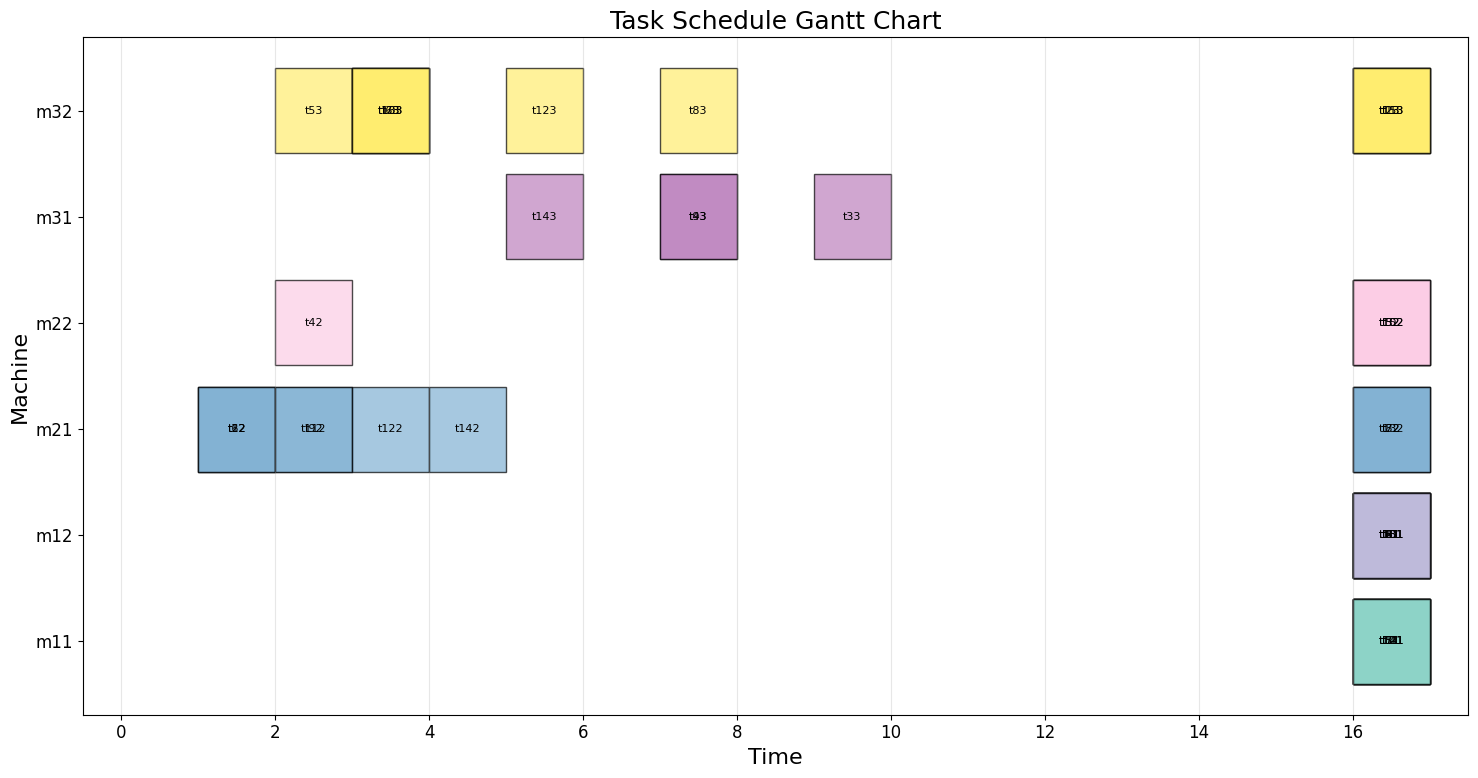

In [360]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def create_gantt_chart(transition_num, sorted_task_schedule, sort_ans):
    # マシンのユニークリストを取得
    machines = sorted(list(set(sorted_task_schedule.values())))
    machine_to_idx = {machine: idx for idx, machine in enumerate(machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = sorted_task_schedule[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(machines)))
    machine_colors = dict(zip(machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        duration = 1  # 各タスクの所要時間を1単位とする
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration/2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=8)
    
    # グラフの装飾
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(int(schedule[1]) for schedule in sort_ans if isinstance(schedule, list))
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# 使用例
fig, ax = create_gantt_chart(transition_num, sorted_task_schedule, sort_ans)
plt.show()

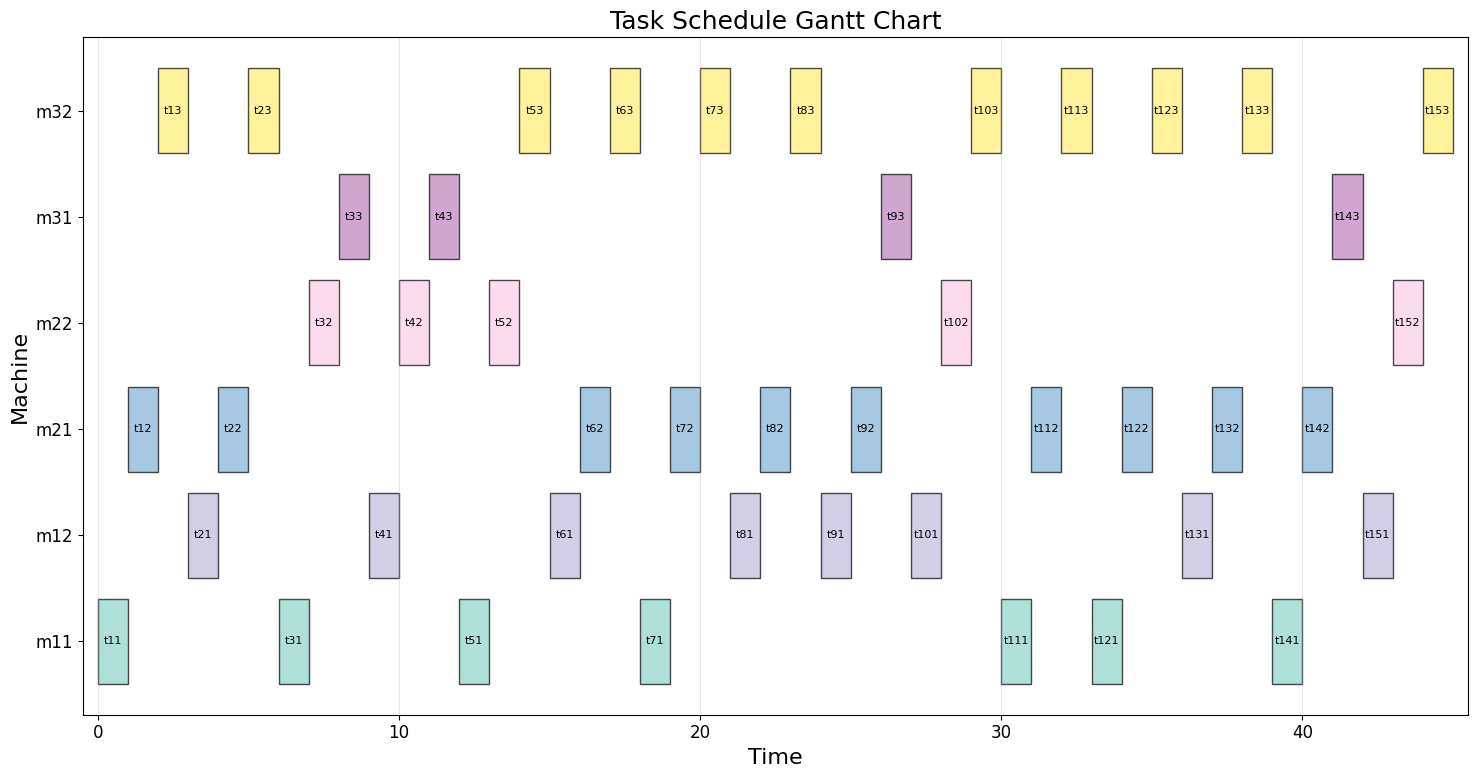

In [361]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def create_gantt_chart(transition_num, sorted_task_schedule, sort_ans):
    # マシンのユニークリストを取得
    machines = sorted(list(set(sorted_task_schedule.values())))
    machine_to_idx = {machine: idx for idx, machine in enumerate(machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得（インデックスを開始時間として使用）
    for idx, schedule in enumerate(sort_ans):
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = sorted_task_schedule[task_name]
                task_details[task_name]['start'] = idx  # インデックスを開始時間として使用
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(machines)))
    machine_colors = dict(zip(machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        duration = 1  # 各タスクの所要時間を1単位とする
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration/2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=8)
    
    # グラフの装飾
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    list_length = sum(1 for _ in sort_ans if isinstance(_, list))
    ax.set_xlim(-0.5, list_length + 0.5)
    
    plt.tight_layout()
    return fig, ax

# 使用例
fig, ax = create_gantt_chart(transition_num, sorted_task_schedule, sort_ans)
plt.show()